In [261]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
import numpy as np
import pandas as pd
import time
import h5py
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
import json
import pandas as pd
%load_ext autoreload
%autoreload 1
%aimport data_processing
from data_processing import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Construct mock SMF

In [ ]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/stellar_mass_functions/'

redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]
bin_width = .1
error = .3

for redshift in redshifts:

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

  #  print(np.amax(galaxies[:, data_keys['Halo_mass']]))
  #  print(np.amin(galaxies[:, data_keys['Halo_mass']]))

    max_stellar_mass = np.amax(galaxies[:, data_keys['Stellar_mass']])
    min_stellar_mass = np.amin(galaxies[:, data_keys['Stellar_mass']])
    lower_bin_edge = np.floor(min_stellar_mass * 10)/10
    upper_bin_edge = np.ceil(max_stellar_mass* 10)/10
   # print(min_stellar_mass, max_stellar_mass)
   # print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_stats = stats.binned_statistic(galaxies[:, data_keys['Stellar_mass']], galaxies[:, data_keys['Stellar_mass']], 
                                       bins=bin_edges)

    bin_counts = [np.sum(bin_stats[2] == i) for i in range(1, n_bins+1)]

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
  #  print(bin_centers)

    #plt.hist(galaxies[:, data_keys['Stellar_mass']], bins = bin_edges, density = False, label = 'Stellar_mass')
  #  plt.scatter(bin_centers, bin_counts)

  #  print(bin_counts)
    bin_counts = [float('nan') if count == 0 else count for count in bin_counts]
    bin_counts_arr = np.array(bin_counts, dtype=np.float)
    bin_counts_per_mpc3 = bin_counts_arr / 200**3 / bin_width
    bin_counts_per_mpc3[bin_counts_per_mpc3 > 0] = np.log10(bin_counts_per_mpc3[bin_counts_per_mpc3 > 0])
  #  print(bin_counts_per_mpc3)

    full_data_list = [[stell_mass, phi, error] for (stell_mass, phi) in zip(bin_centers, bin_counts_per_mpc3) 
                      if (not np.isnan(phi)) ]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})
  #  print(full_data_list)

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

In [ ]:
### Try loading a data file
file_name = 'galaxies.Z00'
with open(destination_directory + file_name + '.json', 'r') as f:
    test = json.load(f)
f.close()
print(test)

## Construct mock SSFR

In [ ]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/ssfr/'
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]

for redshift in redshifts:

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)
    
    bin_width = .2
    error = .3

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

    # print(np.amax(galaxies[:, data_keys['Halo_mass']]))
    # print(np.amin(galaxies[:, data_keys['Halo_mass']]))

    sfr_log = galaxies[:, data_keys['SFR']]
    sfr = np.power(10, sfr_log)
    # print(np.amax(sfr))
    # print(np.amin(sfr))

    stellar_mass_log = galaxies[:, data_keys['Stellar_mass']]
    stellar_mass = np.power(10, stellar_mass_log)
    # print('{:.3e}'.format(np.amax(stellar_mass)))
    # print('{:.3e}'.format(np.amin(stellar_mass)))

    ssfr = sfr / stellar_mass
    ssfr_log = np.log10(ssfr)

    max_stellar_mass = np.amax(stellar_mass_log)
    min_stellar_mass = np.amin(stellar_mass_log)
    lower_bin_edge = np.floor(min_stellar_mass * 10)/10
    upper_bin_edge = np.ceil(max_stellar_mass* 10)/10
    # print(min_stellar_mass, max_stellar_mass)
    # print(lower_bin_edge, upper_bin_edge)
    if (upper_bin_edge - lower_bin_edge) % bin_width > 1e-5 and (upper_bin_edge - lower_bin_edge) % bin_width < bin_width - 1e-5:
    #     print((upper_bin_edge - lower_bin_edge) % bin_width)
    #     print('hej')
        upper_bin_edge += (upper_bin_edge - lower_bin_edge) % bin_width
    # print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_stats_means = stats.binned_statistic(stellar_mass_log, ssfr_log, bins=bin_edges, statistic='mean')
    bin_stats_stds = stats.binned_statistic(stellar_mass_log, ssfr_log, bins=bin_edges, statistic=np.std)
    bin_means = bin_stats_means[0]
    bin_stds = bin_stats_stds[0]
    # print(bin_means)
    # print(bin_stds)

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    # print(bin_edges)
    # print(bin_centers)

    # plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt = 'bo')

    full_data_list = [[stell_mass, mean_ssfr_log, error] for (stell_mass, mean_ssfr_log) in zip(bin_centers, bin_means)]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})
    # print(full_data_list)

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

## Construct mock fraction of quenched galaxies

In [12]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/fq/'
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]

np.seterr(invalid='raise')

for i_red, redshift in enumerate(redshifts):
    scale_factor = 1 / (1 + redshift)

    h_0 = 67.81 / (3.09e19) # 1/s
    h_0 = h_0 * 60 * 60 * 24 * 365 # 1/yr
    h_r = h_0 * np.sqrt(1e-3*scale_factor**(-4) + 0.308*scale_factor**(-3) + 0*scale_factor**(-2) + 0.692)
    ssfr_cutoff = 0.3*h_r
    log_ssfr_cutoff = np.log10(ssfr_cutoff)

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)

    bin_width = .25
    error = .3

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

#     print(np.amax(galaxies[:, data_keys['Halo_mass']]))
#     print(np.amin(galaxies[:, data_keys['Halo_mass']]))

    sfr_log = galaxies[:, data_keys['SFR']]
    sfr = np.power(10, sfr_log)
    # print(np.amax(sfr))
    # print(np.amin(sfr))

    stellar_mass_log = galaxies[:, data_keys['Stellar_mass']]
    stellar_mass = np.power(10, stellar_mass_log)
    # print('{:.3e}'.format(np.amax(stellar_mass)))
    # print('{:.3e}'.format(np.amin(stellar_mass)))

    ssfr = sfr / stellar_mass

    # print(np.min(ssfr), np.max(ssfr))
    # print(h_r)

    ssfr_log = np.log10(ssfr)

    max_stellar_mass = np.amax(stellar_mass_log)
    min_stellar_mass = np.amin(stellar_mass_log)
    lower_bin_edge = np.floor(min_stellar_mass * 1/bin_width)*bin_width
    upper_bin_edge = np.ceil(max_stellar_mass * 1/bin_width)*bin_width
#     print(min_stellar_mass, max_stellar_mass)
#     print(lower_bin_edge, upper_bin_edge)
    if (upper_bin_edge - lower_bin_edge) % bin_width > 1e-5 and (upper_bin_edge - lower_bin_edge) % bin_width < bin_width - 1e-5:
    #     print((upper_bin_edge - lower_bin_edge) % bin_width)
        upper_bin_edge += (upper_bin_edge - lower_bin_edge) % bin_width
#     print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_means, bin_edges, bin_numbers = stats.binned_statistic(stellar_mass_log, ssfr_log, bins=bin_edges, statistic='mean')

    bin_fqs = []
    for bin_num in range(1, n_bins+1):
        try:
            fq = np.sum(ssfr_log[bin_numbers == bin_num] < log_ssfr_cutoff) / len(ssfr_log[bin_numbers == bin_num])
        except:
            if len(ssfr_log[bin_numbers == bin_num]) == 0:
                print('bin number {:d} contains 0 points'.format(bin_num))
                fq = 0
            else:
                print('some other error')
        bin_fqs.append(fq)

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
#     fig = plt.figure(i_red, figsize=(10,7))
#     ax = plt.gca()
#     plt.plot(bin_centers, bin_fqs)
#     ax.set_ylim(bottom=0)
#     ax.set_ylim(top=1)
# #     ax.set_xlim(left=8)
# #     ax.set_xlim(right=12)
#     plt.title('Fraction of quenched galaxies at redshift {:.1f}'.format(redshift))
# #     fig.savefig('fq_Z{:02.0f}.png'.format(redshift*10), bbox_inches = 'tight')
#     plt.show()

# print(bin_edges)
# print(bin_centers)

# plt.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt = 'bo')

    full_data_list = [[stell_mass, fq, error] for (stell_mass, fq) in zip(bin_centers, bin_fqs)]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

### Mock stellar mass halo mass relationship

In [ ]:
original_directory = '/home/magnus/data/galcats_nonzero_sfr_no_density_with_growth_rate_no_lastMajM/'
destination_directory = '/home/magnus/data/mock_data/stellar_halo_mass_relations/'
redshifts = [0, .1, .2, .5, 1, 2, 3, 4, 6, 8]

np.seterr(invalid='raise')

for i_red, redshift in enumerate(redshifts):

    file_name = 'galaxies.Z{:02.0f}'.format(redshift*10)

    bin_width = .2
    error = .3

    galfile = pd.read_hdf(original_directory + file_name + '.h5')
    galaxies = galfile.values
    gal_header = galfile.keys().tolist()

    data_keys = {}
    for col_nr, key in enumerate(gal_header):
        data_keys[key] = col_nr

    # Remove the smaller haloes
    galaxies = galaxies[galaxies[:,data_keys['Halo_mass']] > 10.5, :]

    halo_mass = galaxies[:, data_keys['Halo_mass']]
    stellar_mass = galaxies[:, data_keys['Stellar_mass']]

    min_halo_mass = np.amin(halo_mass)
    max_halo_mass = np.amax(halo_mass)
    
    lower_bin_edge = np.floor(min_halo_mass * 1/bin_width)*bin_width
    upper_bin_edge = np.ceil(max_halo_mass * 1/bin_width)*bin_width
    print(min_halo_mass, max_halo_mass)
    print(lower_bin_edge, upper_bin_edge)

    if (upper_bin_edge - lower_bin_edge) % bin_width > 1e-5 and (upper_bin_edge - lower_bin_edge) % bin_width < bin_width - 1e-5:
        print((upper_bin_edge - lower_bin_edge) % bin_width)
        upper_bin_edge += (upper_bin_edge - lower_bin_edge) % bin_width
#     print(lower_bin_edge, upper_bin_edge)

    bin_edges = np.arange(lower_bin_edge, upper_bin_edge + bin_width, bin_width)
    n_bins = len(bin_edges)-1
    bin_means, bin_edges, bin_numbers = stats.binned_statistic(halo_mass, stellar_mass, bins=bin_edges, statistic='mean')

    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    fig = plt.figure(i_red, figsize=(15,5))
    ax = plt.subplot(121)
    ax.errorbar(bin_centers, bin_means, yerr=error*np.ones(len(bin_centers)), fmt = 'bo')
    ax = plt.subplot(122)
    ax.plot(halo_mass[:10000], stellar_mass[:10000], 'b.', markersize=1)
    plt.suptitle('Stellar masses at redshift {:.1f}'.format(redshift))
    plt.show()

    

    full_data_list = [[halo_mass, stellar_mass, error] for (halo_mass, stellar_mass) in zip(bin_centers, bin_means)]
    full_data_list.insert(0, {'bin_widths': bin_width, 'bin_edges': bin_edges.tolist()})

    with open(destination_directory + file_name + '.json', 'w+') as f:
        json.dump(full_data_list, f)
    f.close()

### Real data, SMF

In [312]:
filename = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(filename, 'r')
#file?
# List all groups
print("Keys: ", list(file.keys()))

Keys:  ['Universe_0']


In [313]:
# Get the universe
universe_0 = file['Universe_0']
#universe_0?
# List all objects in the universe
print("Keys: ", list(universe_0.keys()))

Keys:  ['CSFRD', 'Clustering', 'FQ', 'Model_Parameters', 'SMF', 'SSFR']


In [314]:
# Get the SMF objects from the universe
smf = universe_0['SMF']
#smf?
# List all objects
print("Keys: ", list(smf.keys()))
# Get the dataset 'Data'
data = smf['Data']
print("Keys of Data: ", list(data.keys()))
data_keys = list(data.keys())
model = smf['Model']
sets = smf['Sets']

Keys:  ['Data', 'Model', 'Sets']
Keys of Data:  ['000 Li & White 2009 (z = 0.00 - 0.20)', '001 Baldry 2012 (z = 0.00 - 0.06)', '002 Bernardi 2013 (z = 0.00 - 0.20)', '003 Perez-Gonzalez 2008 (z = 0.00 - 0.20)', '004 Perez-Gonzalez 2008 (z = 0.20 - 0.40)', '005 Perez-Gonzalez 2008 (z = 0.40 - 0.60)', '006 Perez-Gonzalez 2008 (z = 0.60 - 0.80)', '007 Perez-Gonzalez 2008 (z = 0.80 - 1.00)', '008 Perez-Gonzalez 2008 (z = 1.00 - 1.30)', '009 Perez-Gonzalez 2008 (z = 1.30 - 1.60)', '010 Perez-Gonzalez 2008 (z = 1.60 - 2.00)', '011 Perez-Gonzalez 2008 (z = 2.00 - 2.50)', '012 Perez-Gonzalez 2008 (z = 2.50 - 3.00)', '013 Perez-Gonzalez 2008 (z = 3.00 - 3.50)', '014 Perez-Gonzalez 2008 (z = 3.50 - 4.00)', '015 Santini 2012 (z = 0.60 - 1.00)', '016 Santini 2012 (z = 1.00 - 1.40)', '017 Santini 2012 (z = 1.40 - 1.80)', '018 Santini 2012 (z = 1.80 - 2.50)', '019 Santini 2012 (z = 2.50 - 3.50)', '020 Santini 2012 (z = 3.50 - 4.50)', '021 Ilbert 2013 (z = 0.20 - 0.50)', '022 Ilbert 2013 (z = 0.50 - 

In [315]:
print(list(sets))
#sets?

[(39, 0, 0., 0.2, b'Li & White 2009'), (21, 39, 0., 0.06, b'Baldry 2012'), (32, 60, 0., 0.2, b'Bernardi 2013'), (20, 92, 0., 0.2, b'Perez-Gonzalez 2008'), (20, 112, 0.2, 0.4, b'Perez-Gonzalez 2008'), (17, 132, 0.4, 0.6, b'Perez-Gonzalez 2008'), (14, 149, 0.6, 0.8, b'Perez-Gonzalez 2008'), (13, 163, 0.8, 1., b'Perez-Gonzalez 2008'), (13, 176, 1., 1.3, b'Perez-Gonzalez 2008'), (11, 189, 1.3, 1.6, b'Perez-Gonzalez 2008'), (10, 200, 1.6, 2., b'Perez-Gonzalez 2008'), (9, 210, 2., 2.5, b'Perez-Gonzalez 2008'), (7, 219, 2.5, 3., b'Perez-Gonzalez 2008'), (6, 226, 3., 3.5, b'Perez-Gonzalez 2008'), (6, 232, 3.5, 4., b'Perez-Gonzalez 2008'), (19, 238, 0.6, 1., b'Santini 2012'), (15, 257, 1., 1.4, b'Santini 2012'), (13, 272, 1.4, 1.8, b'Santini 2012'), (11, 285, 1.8, 2.5, b'Santini 2012'), (9, 296, 2.5, 3.5, b'Santini 2012'), (8, 305, 3.5, 4.5, b'Santini 2012'), (15, 313, 0.2, 0.5, b'Ilbert 2013'), (13, 328, 0.5, 0.8, b'Ilbert 2013'), (12, 341, 0.8, 1.1, b'Ilbert 2013'), (10, 353, 1.1, 1.5, b'Ilbe

In [ ]:
print(list(model))
#model?

In [316]:
print(list(data['051 Caputi 2011 (z = 3.50 - 4.25)']))
print(list(data))
#data?

[(10.187608, -3.961413, 0.30500004, 0.20634921, -3.1224778, 0.03399385), (10.387609, -4.091413, 0.3069609, 0.20634921, -3.280467, 0.040468), (10.587608, -4.381413, 0.3212865, 0.20634921, -3.4284415, 0.04758609), (10.787608, -4.591413, 0.33320415, 0.20634921, -3.5455637, 0.05404417), (10.987608, -4.7014127, 0.3212865, 0.20634921, -3.5870438, 0.05652275), (11.187608, -5.5314126, 0.6090156, 0.20634921, -3.8794188, 0.07723092), (11.387609, -5.961413, 0.71589094, 0.20634921, -4.661877, 0.16999672)]
['000 Li & White 2009 (z = 0.00 - 0.20)', '001 Baldry 2012 (z = 0.00 - 0.06)', '002 Bernardi 2013 (z = 0.00 - 0.20)', '003 Perez-Gonzalez 2008 (z = 0.00 - 0.20)', '004 Perez-Gonzalez 2008 (z = 0.20 - 0.40)', '005 Perez-Gonzalez 2008 (z = 0.40 - 0.60)', '006 Perez-Gonzalez 2008 (z = 0.60 - 0.80)', '007 Perez-Gonzalez 2008 (z = 0.80 - 1.00)', '008 Perez-Gonzalez 2008 (z = 1.00 - 1.30)', '009 Perez-Gonzalez 2008 (z = 1.30 - 1.60)', '010 Perez-Gonzalez 2008 (z = 1.60 - 2.00)', '011 Perez-Gonzalez 200

In [317]:
midz = (3.5 + 4.25)/2
mida = 1 / (1 + midz)
print(mida)

lowera = 1 / (1 + 4.25)
uppera = 1 / (1 + 3.5)
mida = (uppera + lowera) / 2
print(mida)

0.20512820512820512
0.20634920634920634


In [323]:
# Go through all of the data sets, store only data points within the redshifts the network has been trained to predict
predicted_redshifts = [0, 10]

max_redshift = np.max(predicted_redshifts)
min_redshift = np.min(predicted_redshifts)
min_scalefactor = 1 / (1 + max_redshift)
max_scalefactor = 1 / (1 + min_redshift)
print(min_scalefactor, max_scalefactor,'\n')

observable_data = {
    'surveys': [],
    'scale_factor_range': [],
    'scale_factor': [],
    'stellar_masses': [],
    'abundances': [],
    'errors': []
}

for i_key, key in enumerate(list(data)):
    data_scalefactor = data[key][0][3]
    if data_scalefactor >= min_scalefactor and data_scalefactor <= max_scalefactor:
        observable_data['surveys'].append(key)
        observable_data['scale_factor_range'].extend([[1 / (1 + list(sets)[i_key][3]), 1 / (1 + list(sets)[i_key][2])]] * len(list(data[key])))        
        observable_data['scale_factor'].extend([list(point)[3] for point in list(data[key])])
        observable_data['stellar_masses'].extend([list(point)[0] for point in list(data[key])])
        observable_data['abundances'].extend([list(point)[1] for point in list(data[key])])
        observable_data['errors'].extend([list(point)[2] for point in list(data[key])])

        
# print(observable_data['surveys']) 
print(observable_data['scale_factor_range'])
print(observable_data['scale_factor'])
# print(observable_data['stellar_masses'])
# print(observable_data['abundances'])
# print(observable_data['errors'])

print(len(observable_data['surveys']))
print(len(observable_data['scale_factor']))
print(len(observable_data['stellar_masses']))
print(len(observable_data['abundances']))
print(len(observable_data['errors']))

0.09090909090909091 1.0 

[[0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [0.8333333312637277, 1.0], [

In [322]:
a = [[2]] * 4
print(a)

[[2], [2], [2], [2]]


In [ ]:
data_obj_0 = data[data_keys[0]]
print(list(data_obj_0))
#data_obj_0?

In [6]:
filename = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(filename, 'r')
#file?
# List all groups
print("Keys: ", list(file.keys()))

Keys:  ['Universe_0']


In [7]:
# Get the universe
universe_0 = file['Universe_0']
#universe_0?
# List all objects in the universe
print("Keys: ", list(universe_0.keys()))

Keys:  ['CSFRD', 'Clustering', 'FQ', 'Model_Parameters', 'SMF', 'SSFR']


In [8]:
# Get the SMF objects from the universe
smf = universe_0['SMF']
#smf?
# List all objects
print("Keys: ", list(smf.keys()))
# Get the dataset 'Data'
data = smf['Data']
print("Keys of Data: ", list(data.keys()))
data_keys = list(data.keys())
model = smf['Model']
sets = smf['Sets']

Keys:  ['Data', 'Model', 'Sets']
Keys of Data:  ['000 Li & White 2009 (z = 0.00 - 0.20)', '001 Baldry 2012 (z = 0.00 - 0.06)', '002 Bernardi 2013 (z = 0.00 - 0.20)', '003 Perez-Gonzalez 2008 (z = 0.00 - 0.20)', '004 Perez-Gonzalez 2008 (z = 0.20 - 0.40)', '005 Perez-Gonzalez 2008 (z = 0.40 - 0.60)', '006 Perez-Gonzalez 2008 (z = 0.60 - 0.80)', '007 Perez-Gonzalez 2008 (z = 0.80 - 1.00)', '008 Perez-Gonzalez 2008 (z = 1.00 - 1.30)', '009 Perez-Gonzalez 2008 (z = 1.30 - 1.60)', '010 Perez-Gonzalez 2008 (z = 1.60 - 2.00)', '011 Perez-Gonzalez 2008 (z = 2.00 - 2.50)', '012 Perez-Gonzalez 2008 (z = 2.50 - 3.00)', '013 Perez-Gonzalez 2008 (z = 3.00 - 3.50)', '014 Perez-Gonzalez 2008 (z = 3.50 - 4.00)', '015 Santini 2012 (z = 0.60 - 1.00)', '016 Santini 2012 (z = 1.00 - 1.40)', '017 Santini 2012 (z = 1.40 - 1.80)', '018 Santini 2012 (z = 1.80 - 2.50)', '019 Santini 2012 (z = 2.50 - 3.50)', '020 Santini 2012 (z = 3.50 - 4.50)', '021 Ilbert 2013 (z = 0.20 - 0.50)', '022 Ilbert 2013 (z = 0.50 - 

### Real data, sSFR

In [233]:
filename = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(filename, 'r')

# Get the universe
universe_0 = file['Universe_0']
#universe_0?
# List all objects in the universe
print("Keys: ", list(universe_0.keys()))

Keys:  ['CSFRD', 'Clustering', 'FQ', 'Model_Parameters', 'SMF', 'SSFR']


In [234]:
# Get the SMF objects from the universe
ssfr = universe_0['SSFR']
# List all objects
print("Keys: ", list(ssfr.keys()))
# Get the dataset 'Data'
data = ssfr['Data']
print("Keys of Data: ", list(data.keys()))
data_keys = list(data.keys())
model = ssfr['Model']
sets = ssfr['Sets']

Keys:  ['Data', 'Model', 'Sets']
Keys of Data:  ['000 Salim 2007 UV', '001 Zheng 2007 UV IR', '002 Twite 2012 Ha', '003 Noeske 2007', '004 Tadaki 2011', '005 Whitaker 2012', '006 Daddi 2007', '007 Salmi 2012', '008 Karim 2011', '009 Kajisawa 2010', '010 Reddy 2012', '011 Feulner 2006', '012 Gonzalez 2012', '013 Schaerer 2010', '014 Labbe 2013', '015 McLure 2011', '016 Duncan 2014']


In [235]:
print(list(sets))

[(7, 0, b'Salim 2007 UV'), (16, 7, b'Zheng 2007 UV/IR'), (1, 23, b'Twite 2012 Ha'), (46, 24, b'Noeske 2007'), (1, 70, b'Tadaki 2011'), (60, 71, b'Whitaker 2012'), (8, 131, b'Daddi 2007'), (7, 139, b'Salmi 2012'), (31, 146, b'Karim 2011'), (45, 177, b'Kajisawa 2010'), (8, 222, b'Reddy 2012'), (18, 230, b'Feulner 2006'), (6, 248, b'Gonzalez 2012'), (2, 254, b'Schaerer 2010'), (1, 256, b'Labbe 2013'), (1, 257, b'McLure 2011'), (4, 258, b'Duncan 2014')]


In [236]:
print(list(data[data_keys[1]]))
print(data_keys[1])
print(list(data))

[(0.3, -9.45, 0.3354102, 9.277609, 0.25741458, 1.0229536), (0.3, -9.61, 0.3354102, 9.777609, 0.22101642, 1.02733), (0.3, -9.77, 0.3354102, 10.277609, 0.10755333, 1.0303218), (0.3, -10.17, 0.3354102, 10.777609, 0.03042315, 1.0354959), (0.5, -9.15, 0.3354102, 9.277609, 0.30782375, 1.0229212), (0.5, -9.29, 0.3354102, 9.777609, 0.3066111, 1.0284971), (0.5, -9.55, 0.3354102, 10.277609, 0.19478317, 1.0298146), (0.5, -9.87, 0.3354102, 10.777609, 0.06913193, 1.034656), (0.7, -8.95, 0.3354102, 9.277609, 0.39893788, 1.0229886), (0.7, -9.01, 0.3354102, 9.777609, 0.4029671, 1.0281191), (0.7, -9.32, 0.3354102, 10.277609, 0.2961835, 1.0319338), (0.7, -9.65, 0.3354102, 10.777609, 0.12164215, 1.0348758), (0.9, -8.79, 0.3354102, 9.277609, 0.48199463, 1.0233443), (0.9, -8.84, 0.3354102, 9.777609, 0.48585925, 1.028885), (0.9, -9.07, 0.3354102, 10.277609, 0.40208483, 1.0322409), (0.9, -9.58, 0.3354102, 10.777609, 0.19462804, 1.0357814)]
001 Zheng 2007 UV IR
['000 Salim 2007 UV', '001 Zheng 2007 UV IR', '0

In [238]:
# Go through all of the data sets, store only data points within the redshifts the network has been trained to predict
predicted_redshifts = [0, 10]

max_redshift = np.max(predicted_redshifts)
min_redshift = np.min(predicted_redshifts)
min_scalefactor = 1 / (1 + max_redshift)
max_scalefactor = 1 / (1 + min_redshift)
print(min_scalefactor, max_scalefactor,'\n')

observable_data = {
    'surveys': [],
    'scale_factor': [],
    'stellar_masses': [],
    'ssfr': [],
    'errors': []
}

for i_key, key in enumerate(list(data)):
    for data_point in list(data[key]):
        redshift = data_point[0]
        scale_factor = 1 / (1 + redshift)
        
        if scale_factor >= min_scalefactor and scale_factor <= max_scalefactor:
            if key not in observable_data['surveys']:
                observable_data['surveys'].append(key)
            observable_data['scale_factor'].append(scale_factor)
            observable_data['stellar_masses'].append(data_point[3])
            observable_data['ssfr'].append(data_point[1])
            observable_data['errors'].append(data_point[2])

print(observable_data['surveys'])
# print(observable_data['scale_factor'])
# print(observable_data['stellar_masses'])
# print(observable_data['ssfr'])
# print(observable_data['errors'])
print(len(observable_data['surveys']))
print(len(observable_data['scale_factor']))
print(len(observable_data['stellar_masses']))
print(len(observable_data['ssfr']))
print(len(observable_data['errors']))

0.09090909090909091 1.0 

['000 Salim 2007 UV', '001 Zheng 2007 UV IR', '002 Twite 2012 Ha', '003 Noeske 2007', '004 Tadaki 2011', '005 Whitaker 2012', '006 Daddi 2007', '007 Salmi 2012', '008 Karim 2011', '009 Kajisawa 2010', '010 Reddy 2012', '011 Feulner 2006', '012 Gonzalez 2012', '013 Schaerer 2010', '014 Labbe 2013', '015 McLure 2011', '016 Duncan 2014']
17
262
262
262
262


### Real data, FQ

In [328]:
filename = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(filename, 'r')

# Get the universe
universe_0 = file['Universe_0']
#universe_0?
# List all objects in the universe
print("Keys: ", list(universe_0.keys()))

Keys:  ['CSFRD', 'Clustering', 'FQ', 'Model_Parameters', 'SMF', 'SSFR']


In [329]:
# Get the SMF objects from the universe
fq = universe_0['FQ']
# List all objects
print("Keys: ", list(fq.keys()))
# Get the dataset 'Data'
data = fq['Data']
print("Keys of Data: ", list(data.keys()))
data_keys = list(data.keys())
model = fq['Model']
sets = fq['Sets']

Keys:  ['Data', 'Model', 'Sets']
Keys of Data:  ['000 Drory 2009 Cosmos (z = 0.20 - 0.40)', '001 Drory 2009 Cosmos (z = 0.40 - 0.60)', '002 Drory 2009 Cosmos (z = 0.60 - 0.80)', '003 Drory 2009 Cosmos (z = 0.80 - 1.00)', '004 Wetzel 2012 SDSS (z = 0.00 - 0.10)', '005 Wetzel 2012 SDSS (z = 0.40 - 0.60)', '006 Wetzel 2012 SDSS (z = 0.60 - 0.80)', '007 Wetzel 2012 SDSS (z = 0.80 - 1.00)', '008 Lin 2013 PanStarrs (z = 0.20 - 0.50)', '009 Lin 2013 PanStarrs (z = 0.50 - 0.80)', '010 Ilbert 2013 (z = 0.20 - 0.50)', '011 Ilbert 2013 (z = 0.50 - 0.80)', '012 Ilbert 2013 (z = 0.80 - 1.10)', '013 Ilbert 2013 (z = 1.10 - 1.50)', '014 Ilbert 2013 (z = 1.50 - 2.00)', '015 Ilbert 2013 (z = 2.00 - 2.50)', '016 Ilbert 2013 (z = 2.50 - 3.00)', '017 Moustakas 2013 (z = 0.20 - 0.30)', '018 Moustakas 2013 (z = 0.30 - 0.40)', '019 Moustakas 2013 (z = 0.40 - 0.50)', '020 Moustakas 2013 (z = 0.50 - 0.65)', '021 Moustakas 2013 (z = 0.65 - 0.80)', '022 Moustakas 2013 (z = 0.80 - 1.00)', '023 Muzzin 2013 (z = 0.

In [330]:
print(list(sets))

[(13, 0, 0.2, 0.4, b'Drory 2009 Cosmos'), (11, 13, 0.4, 0.6, b'Drory 2009 Cosmos'), (11, 24, 0.6, 0.8, b'Drory 2009 Cosmos'), (10, 35, 0.8, 1., b'Drory 2009 Cosmos'), (4, 45, 0., 0.1, b'Wetzel 2012 SDSS'), (4, 49, 0.4, 0.6, b'Wetzel 2012 SDSS'), (4, 53, 0.6, 0.8, b'Wetzel 2012 SDSS'), (4, 57, 0.8, 1., b'Wetzel 2012 SDSS'), (8, 61, 0.2, 0.5, b'Lin 2013 PanStarrs'), (8, 69, 0.5, 0.8, b'Lin 2013 PanStarrs'), (18, 77, 0.2, 0.5, b'Ilbert 2013'), (16, 95, 0.5, 0.8, b'Ilbert 2013'), (14, 111, 0.8, 1.1, b'Ilbert 2013'), (13, 125, 1.1, 1.5, b'Ilbert 2013'), (12, 138, 1.5, 2., b'Ilbert 2013'), (10, 150, 2., 2.5, b'Ilbert 2013'), (9, 160, 2.5, 3., b'Ilbert 2013'), (19, 169, 0.2, 0.3, b'Moustakas 2013'), (20, 188, 0.3, 0.4, b'Moustakas 2013'), (18, 208, 0.4, 0.5, b'Moustakas 2013'), (16, 226, 0.5, 0.65, b'Moustakas 2013'), (13, 242, 0.65, 0.8, b'Moustakas 2013'), (11, 255, 0.8, 1., b'Moustakas 2013'), (32, 266, 0.2, 0.5, b'Muzzin 2013'), (27, 298, 0.5, 1., b'Muzzin 2013'), (23, 325, 1., 1.5, b'Muz

In [331]:
print(list(data[data_keys[1]]))
print(data_keys[1])
print(list(data))

[(9.027609, 0.0655, 0.12275765, 0.66964287, 0.12755866, 0.00261202), (9.277609, 0.07411, 0.12315329, 0.66964287, 0.181272, 0.00414625), (9.527609, 0.06964, 0.12533078, 0.66964287, 0.20595632, 0.0053425), (9.777609, 0.10127, 0.12653418, 0.66964287, 0.23083355, 0.00654483), (10.027609, 0.12227, 0.12679197, 0.66964287, 0.24337044, 0.00723704), (10.277609, 0.23546, 0.12184803, 0.66964287, 0.25443494, 0.0075969), (10.527609, 0.30478, 0.12157442, 0.66964287, 0.27380073, 0.0088928), (10.777609, 0.3888, 0.12450377, 0.66964287, 0.44748366, 0.01548928), (11.027609, 0.58726, 0.12268808, 0.66964287, 0.6847525, 0.03000232), (11.277609, 0.71304, 0.1368204, 0.66964287, 0.90574515, 0.06450602), (11.527609, 0.82758, 0.18626896, 0.66964287, 0.97254443, 0.20212042)]
001 Drory 2009 Cosmos (z = 0.40 - 0.60)
['000 Drory 2009 Cosmos (z = 0.20 - 0.40)', '001 Drory 2009 Cosmos (z = 0.40 - 0.60)', '002 Drory 2009 Cosmos (z = 0.60 - 0.80)', '003 Drory 2009 Cosmos (z = 0.80 - 1.00)', '004 Wetzel 2012 SDSS (z = 0.

In [333]:
# Go through all of the data sets, store only data points within the redshifts the network has been trained to predict
predicted_redshifts = [0, 10]

max_redshift = np.max(predicted_redshifts)
min_redshift = np.min(predicted_redshifts)
min_scalefactor = 1 / (1 + max_redshift)
max_scalefactor = 1 / (1 + min_redshift)
print(min_scalefactor, max_scalefactor,'\n')

observable_data = {
    'surveys': [],
    'scale_factor': [],
    'scale_factor_range': [],
    'stellar_masses': [],
    'fq': [],
    'errors': []
}

for i_key, key in enumerate(list(data)):
    scale_factor = data[key][0][3]
        
    if scale_factor >= min_scalefactor and scale_factor <= max_scalefactor:
        observable_data['surveys'].append(list(sets)[i_key][-1])
        observable_data['scale_factor'].extend([list(point)[3] for point in list(data[key])])
        observable_data['scale_factor_range'].extend([[1 / (1 + list(sets)[i_key][3]), 1 / (1 + list(sets)[i_key][2])]] * len(list(data[key])))        
        observable_data['stellar_masses'].extend([list(point)[0] for point in list(data[key])])
        observable_data['fq'].extend([list(point)[1] for point in list(data[key])])
        observable_data['errors'].extend([list(point)[2] for point in list(data[key])])

# print(observable_data['surveys'])
print(observable_data['scale_factor_range'])
print(observable_data['scale_factor'])

# print(observable_data['stellar_masses'])
# print(observable_data['fq'])
# print(observable_data['errors'])
print(len(observable_data['surveys']))
print(len(observable_data['scale_factor']))
print(len(observable_data['stellar_masses']))
print(len(observable_data['fq']))
print(len(observable_data['errors']))

0.09090909090909091 1.0 

[[0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.714285711244661, 0.8333333312637277], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.714285711244661], [0.6249999906867744, 0.7142857

### Real data, CSFRD

In [296]:
filename = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(filename, 'r')

# Get the universe
universe_0 = file['Universe_0']
#universe_0?
# List all objects in the universe
print("Keys: ", list(universe_0.keys()))

Keys:  ['CSFRD', 'Clustering', 'FQ', 'Model_Parameters', 'SMF', 'SSFR']


In [297]:
# Get the CSFRD objects from the universe
csfrd = universe_0['CSFRD']
# List all objects
print("Keys: ", list(fq.keys()))
# Get the dataset 'Data'
data = csfrd['Data']
print("Keys of Data: ", list(data.keys()))
data_keys = list(data.keys())
model = csfrd['Model']
sets = csfrd['Sets']

Keys:  ['Data', 'Model', 'Sets']
Keys of Data:  ['000 Robotham & Driver 2011 UV', '001 Salim 2007 UV', '002 Ly 2011 Ha', '003 Zheng 2006 UV IR', '004 Rujopakarn 2010 FIR', '005 Smolcic 2009 1.4GHz', '006 Shim 2009 Ha', '007 Tadaki 2011 Ha', '008 Sobral 2013 Ha', '009 Hayes 2010 Ha', '010 Karim 2011 1.4Ghz', '011 Ly 2011 UV', '012 Kajisawa 2010 UV IR', '013 Dunne 2009 1.4GHz', '014 Cucciati 2012 UV', '015 Le Borgne 2009 IR mm', '016 Van der Burg 2010 UV', '017 Oesch 2013 UV', '018 McLure 2013 UV', '019 Reddy & Steidel UV', '020 Burgarella 2013 UV IR', '021 Duncan 2014 UV', '022 Bourne 2016 UV IR', '023 Gunawardhana 2015 Ha']


In [298]:
print(list(sets))

[(1, 0, b'Robotham & Driver 2011 UV'), (1, 1, b'Salim 2007 UV'), (1, 2, b'Ly 2011 Ha'), (4, 3, b'Zheng 2006 UV/IR'), (7, 7, b'Rujopakarn 2010 FIR'), (4, 14, b'Smolcic 2009 1.4GHz'), (2, 18, b'Shim 2009 Ha'), (1, 20, b'Tadaki 2011 Ha'), (4, 21, b'Sobral 2013 Ha'), (1, 25, b'Hayes 2010 Ha'), (9, 26, b'Karim 2011 1.4Ghz'), (1, 35, b'Ly 2011 UV'), (4, 36, b'Kajisawa 2010 UV/IR'), (14, 40, b'Dunne 2009 1.4GHz'), (10, 54, b'Cucciati 2012 UV'), (8, 64, b'Le Borgne 2009 IR/mm'), (3, 72, b'Van der Burg 2010 UV'), (15, 75, b'Oesch 2013 UV'), (5, 90, b'McLure 2013 UV'), (2, 95, b'Reddy & Steidel UV'), (9, 97, b'Burgarella 2013 UV/IR'), (4, 106, b'Duncan 2014 UV'), (4, 110, b'Bourne 2016 UV/IR'), (4, 114, b'Gunawardhana 2015 Ha')]


In [299]:
print(list(data[data_keys[0]]))
print(data_keys[0])
print(list(data))

[(0.0565, -1.9145063, 0.11821719, -2.081195)]
000 Robotham & Driver 2011 UV
['000 Robotham & Driver 2011 UV', '001 Salim 2007 UV', '002 Ly 2011 Ha', '003 Zheng 2006 UV IR', '004 Rujopakarn 2010 FIR', '005 Smolcic 2009 1.4GHz', '006 Shim 2009 Ha', '007 Tadaki 2011 Ha', '008 Sobral 2013 Ha', '009 Hayes 2010 Ha', '010 Karim 2011 1.4Ghz', '011 Ly 2011 UV', '012 Kajisawa 2010 UV IR', '013 Dunne 2009 1.4GHz', '014 Cucciati 2012 UV', '015 Le Borgne 2009 IR mm', '016 Van der Burg 2010 UV', '017 Oesch 2013 UV', '018 McLure 2013 UV', '019 Reddy & Steidel UV', '020 Burgarella 2013 UV IR', '021 Duncan 2014 UV', '022 Bourne 2016 UV IR', '023 Gunawardhana 2015 Ha']


In [300]:
# Go through all of the data sets, store only data points within the redshifts the network has been trained to predict
predicted_redshifts = [0, 11]

max_redshift = np.max(predicted_redshifts)
min_redshift = np.min(predicted_redshifts)
min_scalefactor = 1 / (1 + max_redshift)
max_scalefactor = 1 / (1 + min_redshift)
print(min_scalefactor, max_scalefactor,'\n')

observable_data = {
    'surveys': [],
    'scale_factor': [],
    'csfrd': [],
    'errors': []
}

for i_key, key in enumerate(list(data)):
    
    for data_point in list(data[key]):
        redshift = data_point[0]
        scale_factor = 1 / (1 + redshift)
        
        if scale_factor >= min_scalefactor and scale_factor <= max_scalefactor:
            if key not in observable_data['surveys']:
                observable_data['surveys'].append(key)
            observable_data['scale_factor'].append(scale_factor)
            observable_data['csfrd'].append(data_point[1])
            observable_data['errors'].append(data_point[2])
# print(observable_data['surveys'])
# print(observable_data['scale_factor'])
# print(observable_data['csfrd'])
print(observable_data['errors'])
print(len(observable_data['surveys']))
print(len(observable_data['scale_factor']))
print(len(observable_data['csfrd']))
print(len(observable_data['errors']))

0.08333333333333333 1.0 

[0.118217185, 0.10230621, 0.24166091, 0.18370305, 0.14984846, 0.12533078, 0.13189389, 0.12806249, 0.12206556, 0.12806249, 0.12806249, 0.12206556, 0.14866069, 0.17204651, 0.106923446, 0.105446205, 0.10501049, 0.10300529, 0.34153286, 0.35603213, 0.2147091, 0.18069379, 0.12158011, 0.12056543, 0.11327065, 0.2179901, 0.149365, 0.13043796, 0.123839825, 0.10842329, 0.10412012, 0.10731776, 0.11896975, 0.109252, 0.11737165, 0.123839825, 0.1640122, 0.19723083, 0.2147091, 0.2879236, 0.41298968, 0.19546662, 0.16656002, 0.15070689, 0.1445661, 0.14113879, 0.13611951, 0.12464093, 0.12536092, 0.123194166, 0.11419948, 0.1154026, 0.11364858, 0.11981653, 0.2059126, 0.156205, 0.14142135, 0.13453624, 0.13124405, 0.13453624, 0.15239751, 0.30675724, 0.22808988, 0.28792357, 0.26925823, 0.18027756, 0.18027756, 0.18027756, 0.18027756, 0.26925823, 0.31622776, 0.31622776, 0.1874516, 0.16820394, 0.18069379, 0.10440306, 0.14142135, 0.156205, 0.1640122, 0.18027756, 0.18027756, 0.18027756, 0

##### Create a spline functino that approximates the CSFRD

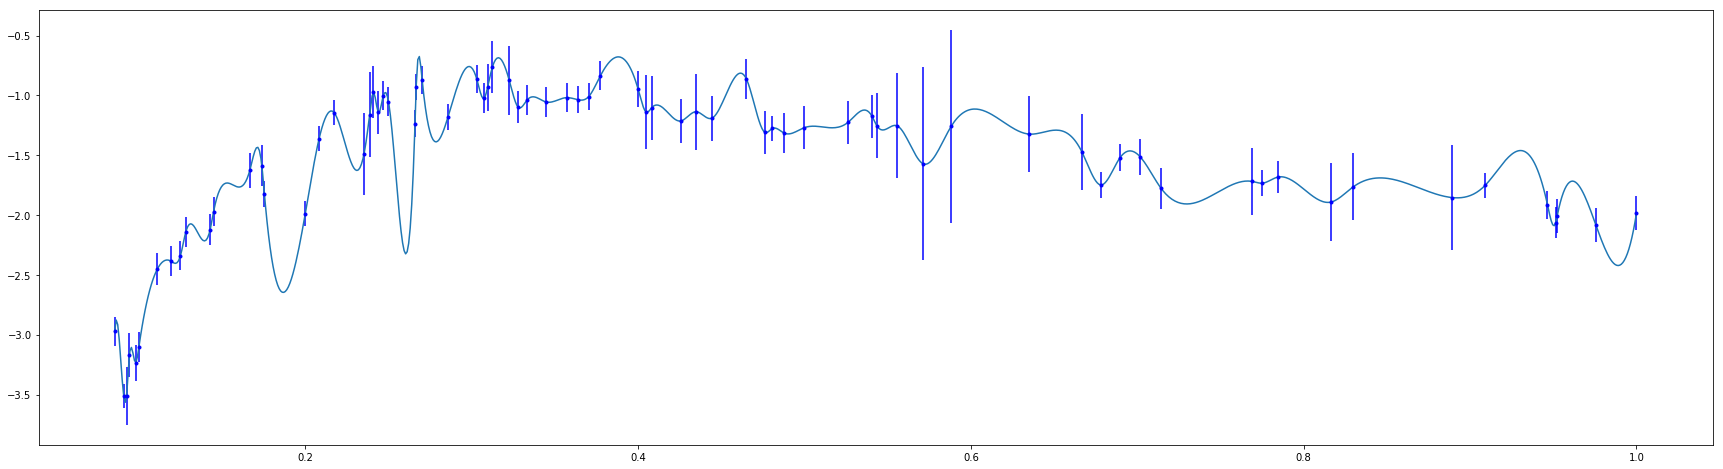

In [310]:
sorted_x = []
sorted_y = []
errs = []

for csfrd_, scale_factor, err in zip(observable_data['csfrd'], observable_data['scale_factor'], observable_data['errors']):
    if scale_factor not in sorted_x:
        sorted_x.append(scale_factor)
        sorted_y.append(csfrd_)
        errs.append(err)
sort_inds = np.argsort(sorted_x)
sorted_x = np.array(sorted_x)[sort_inds]
sorted_y = np.array(sorted_y)[sort_inds]
spline_func = interp1d(sorted_x, sorted_y, kind='cubic')
new_x_points = np.linspace(np.min(observable_data['scale_factor']), np.max(observable_data['scale_factor']), 1000)
fig = plt.figure(figsize=(30,8))
plt.errorbar(sorted_x, sorted_y, yerr=errs, fmt='bo', markersize=3)
plt.plot(new_x_points, spline_func(new_x_points))
plt.show()

In [311]:
a = [1,2,3,4]
b = 1 / (1 + a)
print(b)

TypeError: unsupported operand type(s) for +: 'int' and 'list'

### Using pandas

In [10]:
file_name = '/home/magnus/data/observational_data/all_data.h5'

file = pd.read_hdf(file_name, key='Universe_0')
file_header = file.keys().tolist()
print(file_header)

TypeError: cannot create a storer if the object is not existing nor a value are passed

In [69]:
predicted_redshift = 8
data_to_load = 'smf'

data_dir = '/home/magnus/data/observational_data/all_data.h5'
file = h5py.File(data_dir, 'r')
universe_0 = file['Universe_0']

if data_to_load == 'smf':
    smf = universe_0['SMF']
    data = smf['Data']
    sets = smf['Sets']

    for i_set, dataset in enumerate(list(sets)):
        
        if predicted_redshift >= dataset[2] and predicted_redshift <= dataset[3]:
            print('Redshift {:.2f} - {:.2f}. Survey {}'.format(dataset[2], dataset[3], dataset[-1]))
        
        

Redshift 7.50 - 8.50. Survey b'Song 2009'
